In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow_gnn as tfgnn
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from model import *
from utils import *

In [2]:
negative_methods = ['random_pairs', 'same_degree_distribution', 'most_close', 'most_distant']

k = 5

search_space = {
    'optimizer': Categorical(['sgd', 'adam', 'nadam']),  # the optimizer type
    'learning_rate': Real(1e-6, 1e-2, prior='log-uniform'),  # the learning rate
    'graph_updates': Integer(1, 5),  
}
results = {}

In [3]:
# make and early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, accuracy_score

In [5]:
for method in negative_methods:
    print(f"\nStarting method: {method}")
    
    # Create a graph of protein interactions for each method
    graphToTensor = GraphToTensor(negative_interaction_method=method)
    graph_tensor = graphToTensor.graph_tensor
    
    dataset = create_dataset(graph_tensor, edge_batch_merge)
    
    graph_spec = dataset.element_spec[0]
    input_graph = tf.keras.layers.Input(type_spec=graph_spec)

    # Generate k-folds for each method
    kfolds = graphToTensor.generate_graph_tensors_for_k_folds(k_folds=k)
    
    y_folds = []
    yhat_folds = []

    for i, (train_graph, test_graph) in enumerate(kfolds):
        print(f"\tStarting fold {i+1}/{k}")

        # Create datasets for this fold
        train_dataset = create_dataset(train_graph, edge_batch_merge)
        test_dataset = create_dataset(test_graph, edge_batch_merge)

        model = create_model(input_graph, graph_updates=3)
        
        # Compile the model
        model.compile(
            tf.keras.optimizers.Nadam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['Accuracy']
        )
        
        # Fit the model for this fold
        model.fit(
            train_dataset.repeat(),
            epochs=1000,
            steps_per_epoch=10,
            validation_data=test_dataset.repeat(),
            validation_steps=10,
            callbacks=[early_stopping],
            verbose=0
        )
        
        # Evaluate the model
        yhat = model.predict(test_dataset)
        y = test_dataset.map(lambda graph, labels: labels).unbatch()
        y = np.array(list(y.as_numpy_iterator()))
        yhat = np.array(list(yhat))
        
        y_folds.append(y)
        yhat_folds.append(yhat)
        
        # Delete the model to free up memory
        del model

    # get the predictions for all folds
    y = np.concatenate(y_folds)
    yhat = np.concatenate(yhat_folds)

    # store the results
    results[method] = {
        'ROC AUC': roc_auc_score(y, yhat),
        'Average Precision': average_precision_score(y, yhat),
        'F1': f1_score(y, yhat.round()),
        'Accuracy': accuracy_score(y, yhat.round())
    }


Starting method: random_pairs
	Starting fold 1/5


ValueError: Unknown activation function: leaky relu. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
from pprint import pprint

pprint(results)

{'most_close': {'Accuracy': 0.7560336793392679,
                'Average Precision': 0.9076893982884484,
                'F1': 0.7852748589288492,
                'ROC AUC': 0.8818695430408509},
 'most_distant': {'Accuracy': 0.8941253976925796,
                  'Average Precision': 0.9433580235593289,
                  'F1': 0.9001591029623455,
                  'ROC AUC': 0.9464760716336044},
 'random_pairs': {'Accuracy': 0.6810907221133142,
                  'Average Precision': 0.7581463537563613,
                  'F1': 0.6594017607386178,
                  'ROC AUC': 0.7332563633943664},
 'same_degree_distribution': {'Accuracy': 0.9130539576437318,
                              'Average Precision': 0.9446509065802742,
                              'F1': 0.9174460294454192,
                              'ROC AUC': 0.9492326308028733}}


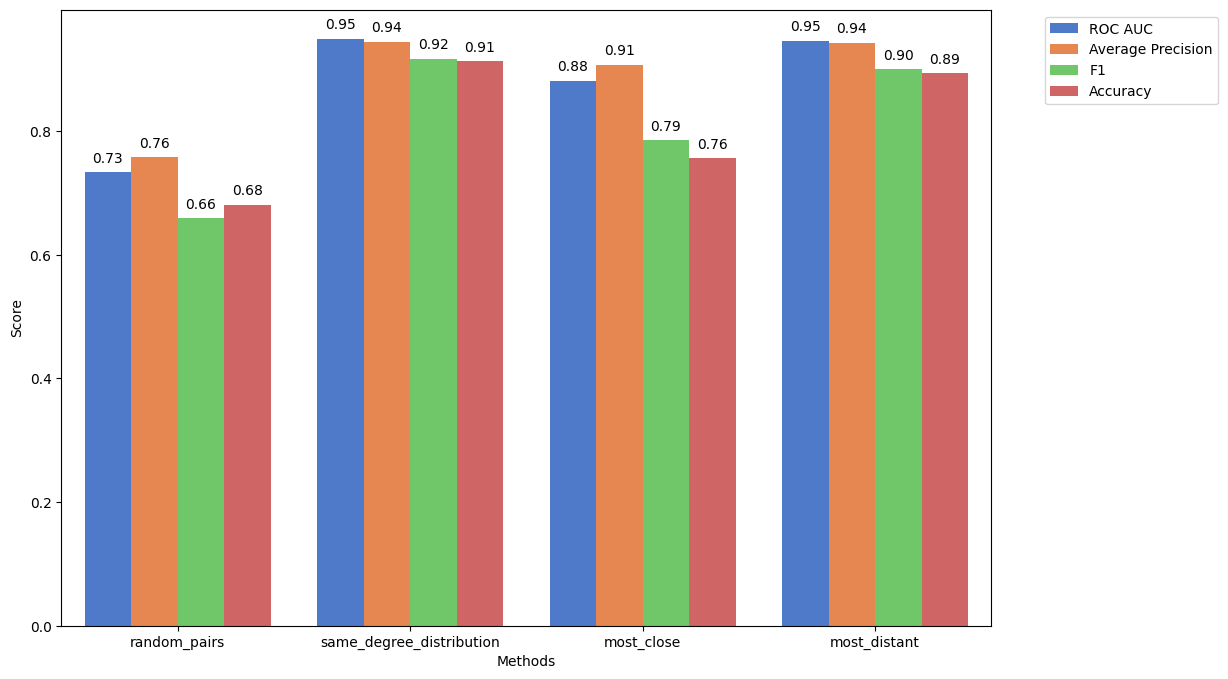

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for DataFrame
data = []
for method, metrics in results.items():
    for metric, score in metrics.items():
        data.append([method, metric, score])

# Create DataFrame
results_df = pd.DataFrame(data, columns=['Methods', 'Metrics', 'Score'])

# Create the plot
plt.figure(figsize=(12,8))
bar_plot = sns.barplot(x='Methods', y='Score', hue='Metrics', data=results_df, palette='muted', saturation=0.9)

# Add labels to the top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'), 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 10), 
                      textcoords = 'offset points')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()